<center>

## MAGICIAN: Mining and gAmblinG servIces sCrapIng and ANalysis

### Matteo Martini 636694

## 1 Setup Ambiente

In [2]:
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

import numpy as np

import time
import requests
import re
from bs4 import BeautifulSoup

dataset_path = "./Datasets/"
def load_datasets(dataset_path):
    transactions = pd.read_csv(dataset_path + 'transactions.csv',header=None)
    inputs    = pd.read_csv(dataset_path +'inputs.csv',header=None)
    outputs   = pd.read_csv(dataset_path + 'outputs.csv',header=None)
    mapping   = pd.read_csv(dataset_path + 'mapAddr2Ids8708820.csv',header=None)
    return inputs,outputs,transactions,mapping

print("Loading data...")
inputs_df, outputs_df,transactions,mapping_df = load_datasets(dataset_path)
print("Done!")
print('Environment ready.')

Loading data...
Done!
Environment ready.


### 1.1. Preprocessing
#### Aggiunta colonne e downscaling dei tipi
La prima cosa evidente quando leggo questi CSV, è che non è presente il column name nei file, dunque per comodità, seguendo la traccia li aggiungerò io.

In aggiunta, downscalerò i tipi default (np.int64) alla minore grandezza possibile, così da risparmiare memoria e quindi tempo nelle operazioni.

In [3]:
print("Adding headers to the dataframes")
transactions.columns = ["timestamp", "block_height", "tx_id", "is_coinbase", "fee"]
# headers mapping
mapping_df.columns = ["hash","addressId" ]
# headers inputs
inputs_df.columns = ["tx_id", "prev_tx_id", "prev_tx_pos"]
# headers outputs
outputs_df.columns = ["tx_id", "position", "addressId", "amount", "script_type"]
print("Done...")

# In aggiunta, andrò a downcastare ad int16 i campi che posso, escudendo i campi sui quali verrà effettuato un merge.
# Questo downcast è possibile in quanto i valori presenti nei campi sono tutti numeri interi
# Andrà in automatico al valore minimo possibile per quel campo
print("Downcasting data...")
# # Transactions
transactions['timestamp'] = pd.to_numeric(transactions['timestamp'], downcast='integer')
transactions['block_height'] = pd.to_numeric(transactions['block_height'], downcast='integer')
# transactions['tx_id'] = pd.to_numeric(transactions['tx_id'], downcast='integer')
transactions['fee'] = pd.to_numeric(transactions['fee'], downcast='integer')

# Convert isCoinbase to categorical if it's binary
transactions['is_coinbase'] = transactions['is_coinbase'].astype('category')

# # Inputs
inputs_df['tx_id'] = pd.to_numeric(inputs_df['tx_id'], downcast='integer')
inputs_df['prev_tx_id'] = pd.to_numeric(inputs_df['prev_tx_id'], downcast='integer')
inputs_df['prev_tx_pos'] = pd.to_numeric(inputs_df['prev_tx_pos'], downcast='integer')

# Outputs
outputs_df['tx_id'] = pd.to_numeric(outputs_df['tx_id'], downcast='integer')
outputs_df['position'] = pd.to_numeric(outputs_df['position'], downcast='integer')
outputs_df['addressId'] = pd.to_numeric(outputs_df['addressId'], downcast='integer')
outputs_df['amount'] = pd.to_numeric(outputs_df['amount'], downcast='integer')
outputs_df['script_type'] = outputs_df['script_type'].astype('category')
# print("Done...")

Adding headers to the dataframes
Done...
Downcasting data...


#### Filtro per le transazioni invalide
Prima di continuare con le analisi e lo scraping dei dati, è importantissimo controllare che le transazioni che abbiamo nel dataset siano valide.
In particolare ci interessa controllare:
 - Che non ci siano input o output che non fanno riferimento ad una transazione reale
 - Input che fanno riferimento a transazioni non esistenti (quindi spendi btc non esistenti)
 - Output con "amount" negativi
 - Transazioni con fees negative
 - Double spending transactions
 - Transazioni con lo stesso id

In [4]:
invalidInput = inputs_df[~ inputs_df.tx_id.isin(transactions['tx_id'])] #Input che non hanno un txId corrispondente in transactions
invalidOutput = outputs_df[~ outputs_df.tx_id.isin(transactions['tx_id'])] #Output che non hanno un txId corrispondente in transactions

print("Invalid inputs: ", invalidInput.shape[0])
print("Invalid outputs: ", invalidOutput.shape[0])
# Sono entrambi vuoti, quindi non ci sono input o output che non hanno un txId corrispondente in transactions (le transazioni sono dunque valide da questo punto di vista)

# Input che non hanno un prevTxId corrispondente in outputs
invalidPrevTxId = inputs_df[~ inputs_df.prev_tx_id.isin(outputs_df['tx_id'])]
print("Invalid prevTxId: ", invalidPrevTxId.shape[0])
# Anche qui sono 0

# Output con amount negativi
invalidAmount = outputs_df[outputs_df.amount < 0]
print("Invalid amount: ", invalidAmount.shape[0])

# Fees negative 
invalidFees = transactions[transactions.fee < 0]
print("Invalid fees: ", invalidFees.shape[0])

# Double spending transactions
double_spending = inputs_df[['tx_id', 'prev_tx_id', 'prev_tx_pos']].merge(transactions[['tx_id', 'timestamp']].astype('int64'), on='tx_id', how='left')
double_spending['group_count'] = double_spending.groupby(['prev_tx_id', 'prev_tx_pos'])['tx_id'].transform('count')
double_spending = double_spending[double_spending['group_count'] > 1]
double_spending.drop(columns=['group_count'], inplace=True)

print("Double spending transactions: ", double_spending.shape[0])


# Same id transactions
same_id = transactions['tx_id'].value_counts()
same_id = same_id[same_id > 1]

print("Same id transactions: ", same_id.shape[0])

Invalid inputs:  0
Invalid outputs:  0
Invalid prevTxId:  0
Invalid amount:  0
Invalid fees:  0
Double spending transactions:  0
Same id transactions:  2


Sfortunatamente quello che notiamo è che esistono due txId che sono correlati a più transazioni. Quello che facciamo allora è eliminarle da transactions, inputs e outputs.

In [5]:
# i txId sono già in same_id, basta semplicemente rimuoverle controllando se il txId è presente nell'index di same_id
transactions = transactions[~ transactions.tx_id.isin(same_id.index)]
inputs = inputs_df[~ inputs_df.tx_id.isin(same_id.index)]
outputs = outputs_df[~ outputs_df.tx_id.isin(same_id.index)]

Adesso che abbiamo effettuato questo passo di preprocessing, non ci sono altre transazioni che risultano invalide, dunque possiamo procedere con la parte di scraping su walleExplorer, per la quale definiamo l'url che useremo e gli header

In [6]:
wallet_explorer_url = "https://www.walletexplorer.com/"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/127.0.0.1 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Referer": "https://www.walletexplorer.com/",
}

headers_address = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/127.0.0.1 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Referer": "https://www.walletexplorer.com/address/",
}


### 1.2 Scraping su WalletExplorer

#### Definizione Funzioni Helper per Scraping

Per recuperare i wallet address da WalletExplorer, predisponiamo delle funzioni per permettere a Selenium di interagire con la pagina web,come richiesto dalla consegna 

**next_page**: prende in input il **driver** di Selenium e cerca nella pagina le etichette **Next**, **Last** per permettere la navigazione verso la prossima pagina

**follow_link**: prende in input il **driver** di Selenium e l'elemento che stiamo cercando, cerca l'elemento nella pagina e se contiene un link lo preme

**scrape_step**: prende in input il **driver** di Selenium e recupera tutti i wallet della pagina, il valore di ritorno è una list comprehension che tramite regex isola gli indirizzi 

In [7]:
#cerco il link alla prossima pagina
def next_page(driver):
    #controllo il testo che walletExplorer usa per permettere la navigazione tra le pagine
    for _ in ("Next","Last"):
        try:
            #cerco l'elemento contenente il link
            element = f'//div[@class="paging"]//a[contains(., "{_}")]'
            return follow_link(driver,element) 
        except:
            return None

def follow_link(driver,element):
    try:
        el = driver.find_element(By.XPATH, element)
        url = el.get_attribute("href")
        el.click()
        return url
    except:
        return None

#step della funzione di scraping, per recuperare tutti i wallet address della pagina
def scrape_step(driver):
    #recupero le entries
    soup = BeautifulSoup(driver.page_source, "html.parser")
    # seleziona tutti gli elementi che hanno l’attributo data-wallet-idsfri
    wallet_elements = soup.select("td a[href^='/address/']") 
    # ritorna una lista con tutti gli elementi
    return [re.search(r"/address/([^/?#]+)", w.get("href")).group(1) for w in wallet_elements if w.get("href") and re.search(r"/address/([^/?#]+)", w.get("href"))]




#### Definizione Funzione per Scraping

La funzione di scraping, crea un driver di Selenium su chrome, si collega all'url di walletExplorer e ricerca il **wallet_name** che gli viene passato come formale, successivamente invoca la funzione **find_wallet_addresses**, che fornisce la visualizzazione di tutti i wallet address del wallet preso in analisi.
<br>Successivamente si procede step-by-step grazie alla funzione **scrape_step** e si termina solo quando la funzione **next_page** ritorna **None** indicando che non ci sono altre pagine da consultare, ed infine prima di terminare la funzione chiude il driver istanziato all'inizio
<br>Nota a margine, la funzione è un generatore per permettere all'utilizzatore di scegliere la struttura dati con cui memorizzare le liste di indirizzi

In [8]:
def scrape_wallet_explorer(wallet_name):
    driver = webdriver.Chrome() 
    driver.get(wallet_explorer_url)
    
    #ricerca del wallet tramite form
    driver.find_element(By.NAME,'q').send_keys(wallet_name)
    driver.find_element(By.TAG_NAME,'form').submit()
    
    #mettere funzione di Selenium, il sito è in down
    time.sleep(1)
    wallet_addresses_link = '//span[@class="showother"]//a[contains(., "show wallet addresses")]'
    #mostra wallet
    clicked = follow_link(driver,wallet_addresses_link)

    # find_wallet_addresses(driver,"show wallet addresses")
    if clicked == None: return
    #mettere funzione di selenium
    time.sleep(1)

    try:
        while True:
            #recupero di tutti gli input/output della pagina
            yield from scrape_step(driver)
            if next_page(driver) == None:break;
    except:
            print('Something went wrong')
    finally:
        driver.close()


#### 1.2.1 Data Retrieval

Procediamo adesso col recuperare tutti i **wallet address** di nostro interesse da WalletExplorer, tramite la funzione **scrape_wallet_explorer**

In [9]:
deepbit_hashed_addresses = set(scrape_wallet_explorer('DeepBit.net'))
diceoncrack_hashed_addresses = set(scrape_wallet_explorer('DiceonCrack'))

### 1.3 Preparazione Dataframe

#### 1.3.1 Dataframe per analisi relative a Deepbit.net

##### Preparazione dati preliminari
Dovendo eseguire varie analisi sulle transazioni coinbase vado a predisporre un **set di indirizzi Deepbit.net**, sfruttando i **wallet address** recuperati in precedenza, inoltre per comodità creo un dataframe **merged_outputs** facendo un merge tra outputs_df e mapping_df per ottenere output con indirizzi hashati.

In [10]:
#deepbit_transactions -> deepbi_hashed_addresses
deepbit_addresses = set(mapping_df[mapping_df["hash"].isin(deepbit_hashed_addresses)]["addressId"])

merged_outputs = outputs_df.merge(mapping_df,on="addressId",how="left")
#filtro gli output di deepbit
bnet_out = merged_outputs[merged_outputs["hash"].isin(deepbit_hashed_addresses)]

#individuo le transazioni di deepbit tramite bnet_out
deepbit_transactions = transactions[transactions["tx_id"].isin(bnet_out["tx_id"].unique())]

#Creo due dataframe da usare per i merge, in quanto pandas crea problemi se le colonne del merge hanno tipo diverso da int64, ma se sono indici non ha alcun problema
indexed_in = inputs_df.copy().set_index(["prev_tx_id","prev_tx_pos"])
indexed_out = outputs_df.copy().rename(columns={"tx_id":"prev_tx_id","position":"prev_tx_pos"}).set_index(["prev_tx_id","prev_tx_pos"])

##### Preparazione Dataframe per analizzare transazioni Coinbase
<center>
    <img src="images/transaction_pattern.png" width="500">

<br>

Seguendo il pattern dell'immagine andiamo a filtrare innanzitutto le transazioni coinbase in **all_coinbase**, successivamente filtriamo gli input che hanno **prev_tx_id** == **tx_id** per controllare quali input sono coinbase, andiamo poi ad evidenziare le transazioni che inviano a deepbit, considerando il **tx_id** degli **input_from_coinbase** e quello di **deepbit_transactions**. Infine otteniamo la totalità delle coinbase dirette verso deepbit filtrando **all_coinbase** sul **tx_id** verificando che sia corrispondente al **prev_tx_id** di **transactions_to_deepbit** 

In [11]:
#filtro le transazioni coinbase
all_coinbase = transactions[transactions['is_coinbase']==1].copy()
#filtro gli input coinbase
inputs_from_coinbase = inputs_df[inputs_df['prev_tx_id'].isin(all_coinbase['tx_id'])]
#filtro le transazioni verso deepbit
transactions_to_deepbit = inputs_from_coinbase[inputs_from_coinbase["tx_id"].isin(deepbit_transactions['tx_id'])]
#ottengo tutte le coinbase di deepbit
coinbase_deepb = all_coinbase[all_coinbase['tx_id'].isin(transactions_to_deepbit['prev_tx_id'])]

##### Preparazione Dataframe per analizzare le fee dei Miner

Per calcolare le fee delle transazioni andiamo, a creare il dataframe **amount** unendo i due dataframe **indexed** , sulle colonne indice, quindi estraiamo da **amount** gli **input_amount**, e da **outputs_df** gli **output_amount**. 

Queste Series rappresentano rispettivamente la quantità di bitcoin in entrata/uscita da una transazione e ci serviranno per calcolare le fee, che si ottiene con la differenza tra questi valori,pertanto andiamo ad unire le series creando così il dataframe **fee**, che andrà unito tramite merge al dataframe **non_coinbase_deepbit_transactions** che contiene **block_height** e **tx_id** delle transazioni non coinbase di deepbit.net.<br>
Il dataframe **non_coinbase_deepbit_transactions** è stato creato filtrando tramite le maschere **not_coinbase** ed **is_deepbit_block**<br>
Successivamente aggiungeremo una colonna omonima nel dataframe **fee**, i quali valori saranno il risultato di `input_total[i] - output_total[i]` dove **i** è l'indice di riga
Le transazioni coinbase sono speciali perché creano nuovi bitcoin dal nulla e non hanno input reali, quindi non pagano fee. Per questo motivo, le escludiamo dalla nostra analisi.

Infine, aggreghiamo tutte le fee per blocco, sommando le fee di tutte le transazioni incluse in ciascun blocco.
Il risultato finale ci mostra quanto ogni miner ha guadagnato in fee per ogni blocco minato, che insieme alla **block reward** costituisce la ricompensa totale del miner.

In [12]:
#Amount singole transazioni
amounts = indexed_in.merge(indexed_out,how="inner",left_index=True,right_index=True)

#recupero amount in ingresso/uscita
input_amount = amounts.groupby('tx_id')["amount"].sum().rename('input_total')
output_amount = outputs_df.groupby('tx_id')['amount'].sum().rename('output_total')

#Concateno gli amount e creo fee
fees = pd.merge(input_amount,output_amount,on="tx_id",how="inner")

#tolgo l'indicizzazione e ridenomino la colonna index in tx_id
fees = fees.reset_index().rename(columns={'index':'tx_id'})
#filtro il dataframe transactions su is_coinbase e prendo solo le colonne tx_id e block_height
not_coinbase = (transactions["is_coinbase"] == 0)
is_deepbit_block = (transactions["block_height"].isin(coinbase_deepb["block_height"].unique()))

non_coinbase_deepbit_tx = transactions[ not_coinbase & is_deepbit_block][["tx_id","block_height"]]
#unisco il dataframe fee al filtraggio di transactions per poter verficare quali fee provengano da transazioni non coinbase
fees = fees.merge(non_coinbase_deepbit_tx,on='tx_id',how='left')

#creo la colonna fee, sottraendo ad ogni input il suo output
fees['fee'] = fees['input_total'] - fees['output_total']

#ottengo le fee per ogni blocco raggruppando in base a block_height nella colonna fee
fee_per_deepbit_block = fees.groupby('block_height')['fee'].sum().reset_index()


##### Preparazione Dataframe per analizzare gli UTXO(Unspent Transaction Outputs)

Il primo passo consiste nell'identificare quali output di transazioni non sono mai stati spesi. Per farlo, uniamo il dataframe **indexed_out** con il dataframe **amounts**, che contiene gli input che hanno effettivamente speso degli output. 
Utilizziamo un merge di tipo "left" con l'indicatore _merge per capire quali output della tabella di sinistra non hanno una corrispondenza a destra.
Gli output che risultano marcati come left_only sono proprio quelli che non sono mai stati utilizzati come input in nessuna altra transazione, quindi sono unspent. Questi rappresentano bitcoin che esistono ancora sulla blockchain e che potrebbero essere spesi in futuro.

Una volta identificati questi output non spesi, puliamo il dataframe rimuovendo le colonne che sono completamente vuote (quelle che derivano dal merge e che non hanno trovato corrispondenza). Resettiamo anche l'indice per avere un dataframe più pulito e ridenominiamo alcune colonne per maggiore chiarezza, in particolare trasformiamo prev_tx_id in tx_id perché ora rappresenta la transazione che ha generato questo output non speso.
A questo punto abbiamo tutti gli UTXO dell'intero dataset, ma la consegna richiede solo quelli relativi a Deepbit.net. Filtriamo quindi il dataframe mantenendo solo gli output non spesi che appartengono agli indirizzi di Deepbit, identificati tramite gli addressId che abbiamo precedentemente recuperato.

In [13]:
#Calcolo UTXO
diff = indexed_out.merge(amounts,how="left",on=["prev_tx_id","prev_tx_pos"], indicator=True)
left_only = (diff['_merge'] == 'left_only')
#lo faccio in due passate parte per migliorare la leggibilità
unspent = diff[left_only].dropna(axis=1,how="all").reset_index()
unspent = unspent.rename(columns={"amount_x":"amount","addressId_x":"addressId","script_type_x":"script_type","prev_tx_id":"tx_id"})

deepbit_utxo = unspent["addressId"].isin(deepbit_addresses)

# #Trasformazione Timestamp
UTXO_df = unspent[deepbit_utxo].merge(transactions,how="left",on="tx_id")[["amount","timestamp"]]


#### 1.3.2 Dataframe per analisi relative a DiceOnCrack

Per le analisi di DiceOnCrack(DOC) ci serviranno meno informazioni, fortunatamente.
È quindi sufficiente individuare tutte le transazioni che presentano almeno un indirizzo appartenente a DiceOnCrack e successivamente li ordiniamo in senso crescente per **block_height** ed infine trasformo il timestamp in formato **datetime**

In [14]:
#individuo gli output relativi a DiceOnCrack(DOC)
doc_outs = merged_outputs[merged_outputs["hash"].isin(diceoncrack_hashed_addresses)]
#Preparo il dataframe per il merge
doc_to_merge = doc_outs[["tx_id","position","addressId"]].rename(columns={"tx_id":"prev_tx_id","position":"prev_tx_pos"}).set_index(["prev_tx_id","prev_tx_pos"])

doc_inputs = indexed_in.merge(doc_to_merge,how="inner",left_index=True,right_index=True)

doc_trans_id = np.union1d(doc_inputs["tx_id"].unique(),doc_outs["tx_id"].unique())

doc_trans = transactions[transactions["tx_id"].isin(doc_trans_id)].sort_values("block_height")

doc_trans["timestamp"] = pd.to_datetime(doc_trans["timestamp"],unit='s')

## 2 Analisi Transazioni di DeepBit.Net

Analisi delle Fee per blocco minato da DeepBit.Net

Fee minima: 0.00 satoshi
Fee massima: 6752500000.00 satoshi
Fee mediana: 2000000.00 satoshi
Fee media: 5767611.90 satoshi
Blocchi con fee = 0: 756
Blocchi con fee > 1 BTC: 52


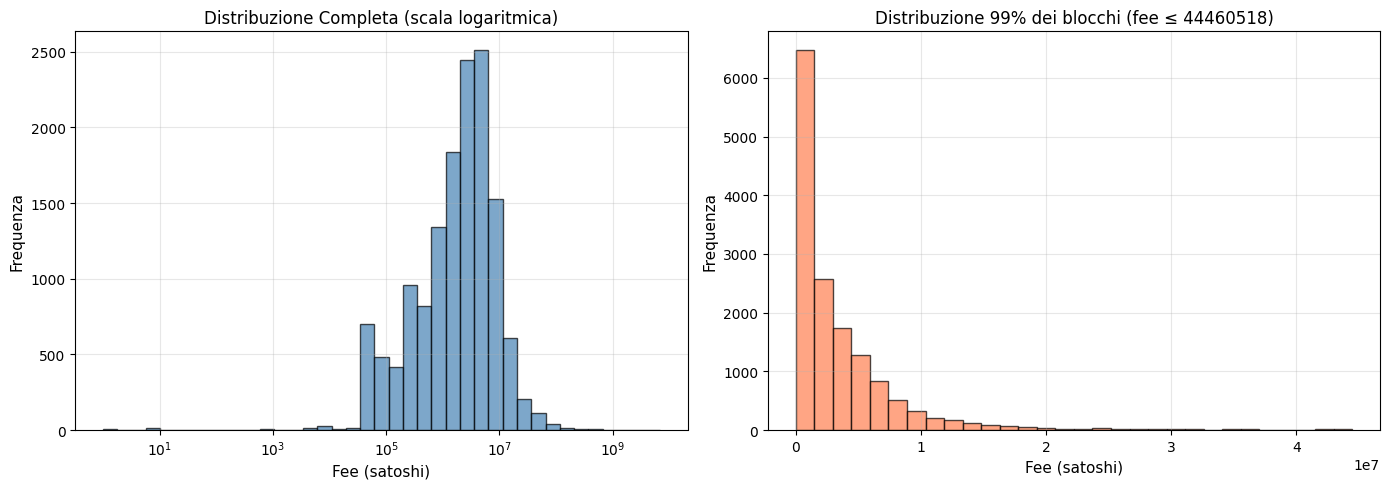


 Top 5 blocchi con fee più alte:
       block_height         fee
3647       164382.0  6752500000
14436      209782.0  5900334758
3648       164383.0  1911693746
3179       163059.0  1898112999
2305       160593.0  1000308704


In [39]:
# Analisi statistica delle fee
print(f"Fee minima: {fee_per_deepbit_block['fee'].min():.2f} satoshi")
print(f"Fee massima: {fee_per_deepbit_block['fee'].max():.2f} satoshi")
print(f"Fee mediana: {fee_per_deepbit_block['fee'].median():.2f} satoshi")
print(f"Fee media: {fee_per_deepbit_block['fee'].mean():.2f} satoshi")
print(f"Blocchi con fee = 0: {(fee_per_deepbit_block['fee'] == 0).sum()}")
print(f"Blocchi con fee > 1 BTC: {(fee_per_deepbit_block['fee'] > 100000000).sum()}")

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Scala logaritmica con bins corretti
fee_nonzero = fee_per_deepbit_block[fee_per_deepbit_block['fee'] > 0]['fee']
logbins = np.logspace(np.log10(fee_nonzero.min()), np.log10(fee_nonzero.max()), 40)
axes[0].hist(fee_nonzero, bins=logbins, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Fee (satoshi)', fontsize=11)
axes[0].set_ylabel('Frequenza', fontsize=11)
axes[0].set_title('Distribuzione Completa (scala logaritmica)', fontsize=12)
axes[0].set_xscale('log')
axes[0].grid(True, alpha=0.3)

# Grafico 2: Distribuzione senza outliers (99° percentile)
fee_99percentile = fee_per_deepbit_block['fee'].quantile(0.99)
fee_filtered = fee_per_deepbit_block[fee_per_deepbit_block['fee'] <= fee_99percentile]['fee']
axes[1].hist(fee_filtered, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Fee (satoshi)', fontsize=11)
axes[1].set_ylabel('Frequenza', fontsize=11)
axes[1].set_title(f'Distribuzione 99% dei blocchi (fee ≤ {fee_99percentile:.0f})', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identifica i blocchi con fee anomale
outliers = fee_per_deepbit_block[fee_per_deepbit_block['fee'] > fee_99percentile].sort_values('fee', ascending=False)
print(f"\n Top 5 blocchi con fee più alte:")
print(outliers.head())


La distribuzione delle fee mostra un pattern log-normale centrato su ~10^7 satoshi (0.1 BTC), coerente con il volume di transazioni del periodo 2009-2012. 

Gli outliers verso destra suggeriscono la presenza di blocchi con errori nel calcolo delle fee, fenomeno documentato nei primi anni di Bitcoin.


### Considerazione del Mining dei blocchi nel tempo

C:\Users\matte\AppData\Local\Temp\ipykernel_14808\3821932450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coinbase_deepb['datetime'] = pd.to_datetime(coinbase_deepb['timestamp'], unit='s')


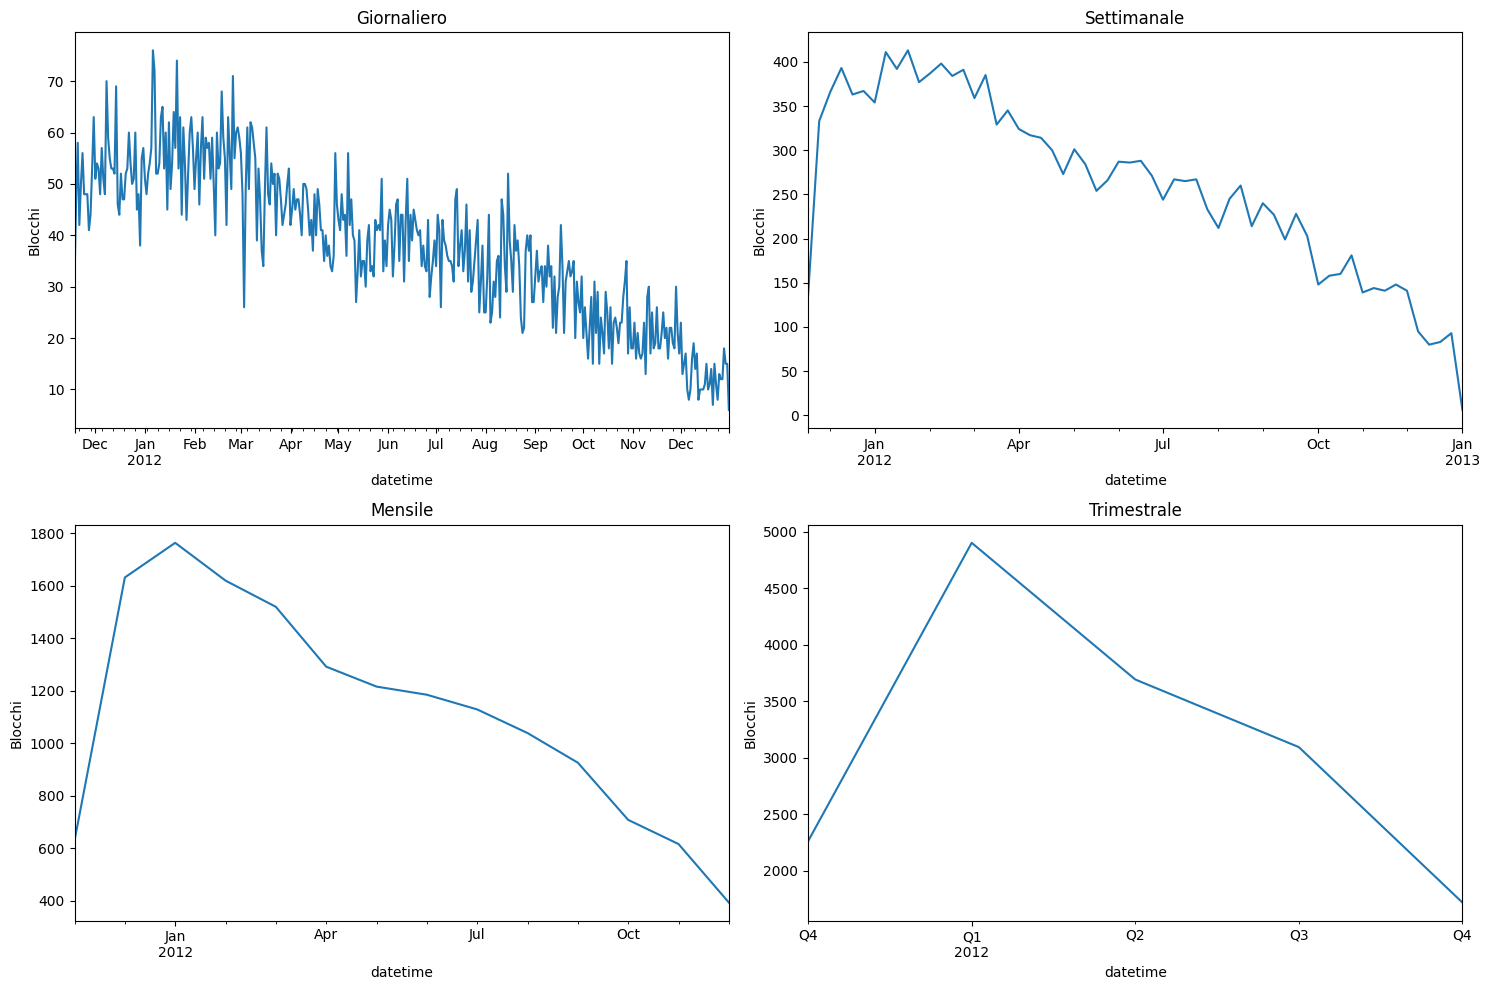

In [18]:
# Imposta timestamp come index (una volta sola)
coinbase_deepb['datetime'] = pd.to_datetime(coinbase_deepb['timestamp'], unit='s')
coinbase_deepb_indexed = coinbase_deepb.set_index('datetime')

# Diversi campionamenti
daily = coinbase_deepb_indexed.resample('D').size()
weekly = coinbase_deepb_indexed.resample('W').size()
monthly = coinbase_deepb_indexed.resample('ME').size()
quarterly = coinbase_deepb_indexed.resample('QE').size()

# Visualizzazione comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

daily.plot(ax=axes[0,0], title='Giornaliero', ylabel='Blocchi')
weekly.plot(ax=axes[0,1], title='Settimanale', ylabel='Blocchi')
monthly.plot(ax=axes[1,0], title='Mensile', ylabel='Blocchi')
quarterly.plot(ax=axes[1,1], title='Trimestrale', ylabel='Blocchi')

plt.tight_layout()
plt.show()

### Analisi degli UTXO(Unspent Transaction Output)

Infine, per analizzare come questi UTXO variano nel tempo, uniamo il dataframe filtrato con la tabella delle transazioni per recuperare il timestamp di quando ciascun output è stato creato. Convertiamo il timestamp da formato Unix (secondi dal 1970) a un formato datetime leggibile, e lo impostiamo come indice del dataframe. Questo ci prepara per successive analisi temporali, come il resample mensile per vedere l'accumulo di bitcoin non spesi nel tempo.

<Axes: title={'center': 'UTXO Deepbit.net per mese (cumulativo)'}, xlabel='timestamp', ylabel='BTC non spesi'>

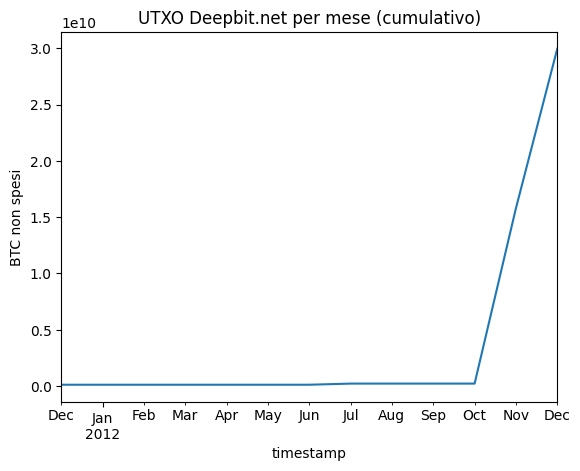

In [19]:
# Numero di transazioni per mese
UTXO_df["timestamp"] = pd.to_datetime(UTXO_df["timestamp"],unit="s")
UTXO_df = UTXO_df.set_index("timestamp")

monthly_utxo = UTXO_df.resample('ME')['amount'].sum()
cumulative_utxo = monthly_utxo.cumsum()
cumulative_utxo.plot(title='UTXO Deepbit.net per mese (cumulativo)', ylabel='BTC non spesi')

### Interpretazione

Il grafico mostra l'accumulo degli UTXO (Bitcoin non spesi) associati a Deepbit.net 
nel corso del 2012. Il pattern rivela due fasi distinte:

**Fase di Stasi (Gennaio-Ottobre 2012)**: Gli UTXO rimangono pressoché costanti a valori prossimi 
allo zero, indicando che Deepbit.net redistribuiva regolarmente i Bitcoin ricevuti ai propri miners, 
mantenendo un bilancio operativo minimo. Questo comportamento è coerente con il modello di business 
di una mining pool che agisce come intermediario senza accumulo di capitale.

**Crescita Esponenziale (Novembre-Dicembre 2012)**: Si osserva un'impennata improvvisa che porta 
l'accumulo a ~3×10^10 satoshi (circa 300 BTC). Questo cambiamento radicale può essere spiegato da:
- **Riduzione dell'attività di payout**: La mining pool potrebbe aver sospeso o rallentato i pagamenti ai miners
- **Preparazione alla chiusura**: Deepbit.net cessò le operazioni nel 2013; questo accumulo potrebbe 
  rappresentare la fase di wind-down prima della chiusura definitiva
- **Cambio di strategia operativa**: Modifica nelle politiche di distribuzione delle ricompense

La discontinuità netta suggerisce un evento deliberato piuttosto che una crescita organica, 
supportando l'ipotesi della cessazione programmata del servizio.


### Definizione funzioni per la ricostruzione della catena di Transazioni

Per ricostruire la catena di transazioni ci appoggeremo ad alcune funzioni che sono state divise per funzionalità:

**find_input**: restituisce **l'input** della catena, individuato mediante **tx_id** e **position** passati come formali alla funzione

**find_related_outputs**: restituisce tutti gli **output** facendo un passo della catena, ossia andando prima ad invocare **find_input** e poi successivamente andando a filtrare **outputs_df** con il **next_tx_id** appena ricavato dalla chiamata di funzione

In [20]:
def find_input(output_tx_id,output_position):
    tx_id_mask = inputs_df["prev_tx_id"]== output_tx_id
    tx_pos_mask = inputs_df["prev_tx_pos"]==output_position
    #cerco il prossimo input della catena
    next = inputs_df[tx_id_mask & tx_pos_mask ]
    
    return int(next.iloc[0]["tx_id"]) 

def find_related_outputs(output_tx_id,output_position):

    next_tx_id = find_input(output_tx_id,output_position)
    #maschere per ottenere l'output
    outputs_tx_id_mask = outputs_df["tx_id"] == (next_tx_id)
    
    return outputs_df[ outputs_tx_id_mask ]


La funzione **separate_addresses** separa una lista di indirizzi, **address_list**, usando un set di indirizzi, **address_set**, restituendo quindi 2 liste, **match** con tutti gli indirizzi che sono presenti anche nel set e **others** con gli indirizzi che non sono presenti nel set

In [21]:

def separate_addresses(address_list, address_set):
    matches = []
    others = []
    for address in address_list:
        if address in address_set:
            matches.append(address)
        else:
            others.append(address)
    return matches, others


Infine la funzione che ci permette di ricostruire la catena, ottenendo informazioni è **chain_transactions** prende come formale **chain_output**, ossia l'output da cui inizieremo la catena e tramite un ciclo while invoca **find_related_outputs** per avere tutti gli output di quella iterazione, successivamente ottiene le liste di indirizzi tramite **separate_addresses**; Se **deepbit_matches** ha più di 1 indirizzo allora la catena è conclusa, altrimenti si cerca il prossimo output filtrando tramite **addressId** il dataframe **related_outputs** e si salvano le informazioni nella lista **change_address_transactions** per poterle analizzare successivamente, per lo stesso motivo salviamo in **othersDeepbit** gli indirizzi che non appartengono a **DeepBit.net** ed in **change_addresses** tutti i change address. Finito il ciclo la funzione ritorna in ordine **change_addresses**, **change_addresses_transactions**, **othersDeepbit**

In [22]:

def chain_transactions(chain_output):
    othersDeepbit = []
    change_addresses_transactions = []
    change_addresses = []
    while True:
        #cerco gli output
        related_outputs = find_related_outputs(chain_output["tx_id"],chain_output["position"])
        #Separo gli indirizzi
        deepbit_matches,others = separate_addresses(related_outputs["addressId"],deepbit_addresses)
        #estendo othersDeepbit per poterlo ritornare
        othersDeepbit.extend(others)

        if len(deepbit_matches) != 1:break
        
        #ricavo il prossimo output
        chain_output = related_outputs[related_outputs["addressId"] == deepbit_matches[0]].iloc[0]
        change_addresses.append(int(chain_output["tx_id"]))
        #memorizzo il tx_id per poter riutilizzare le transazioni
        change_addresses_transactions.append(
            {
                "tx_id":      int(chain_output["tx_id"]),
                "position":   int(chain_output["position"]),
                "addressId":  int(chain_output["addressId"]),
                "amount":     float(chain_output["amount"])
            }
        )
    
    return change_addresses,change_addresses_transactions,othersDeepbit

### Analisi Catena Transazioni a partire dalla transazione con tx_id = 1883820

In [23]:
root_transaction = transactions[transactions["tx_id"] == 1883820];
root_output = outputs_df[outputs_df["tx_id"] == 1883820]

chain_tx_ids,change_addresses_transactions,othersDeepbit = chain_transactions(root_output.iloc[0])

#### Rappresentazione della catena mediante grafo

Per farlo definiamo una funzione **create_graph** che si occuperrà della creazione di un grafo sfruttando le informazioni del dizionario **change_address_transactions** passato come formale.

Per creare il grafo vengono considerate tutte le coppie di transazioni consecutive e per analisi successive andiamo a calcolare **dt** delta_time, e **da** delta_amount, infine aggiungiamo al grafo **G** i due nodi che verranno collegati tra loro mediante un'arco con **l'amount** speso da **t1** verso **t2**. La funzione quindi ritorna la lista **differences** contenente **dt** e **da** per tutte le coppie di transazioni consecutive ed il grafo **G** appena creato

In [24]:

# aggiungo archi tra tx consecutive
def create_graph(change_addresses_transactions):
    G = nx.DiGraph()
    differences =[]
    for i in range(len(change_addresses_transactions) - 1):
        t1 = f't{i+1}'
        t2 = f't{i+2}'
        stamp1 = int(transactions[transactions["tx_id"] == change_addresses_transactions[i]["tx_id"]].iloc[0]["timestamp"])
        stamp2 = int(transactions[transactions["tx_id"] == change_addresses_transactions[i+1]["tx_id"]].iloc[0]["timestamp"])
        dt = stamp1 - stamp2
        da = change_addresses_transactions[i]["amount"] - change_addresses_transactions[i+1]["amount"]
        
        if dt < 0 : dt *= -1 

        differences.append({"delta_time":dt,"delta_amount":da})
        
        G.add_edge(t1, t2,label = change_addresses_transactions[i]["amount"])
    return differences,G


Adesso possiamo quindi creare il grafo tramite la funzione **create_graph** e per visaulizzarlo abbiamo scelto uno spring layout in quanto è quello che si presat meglio per un grafo diretto di queste dimensioni.

Nota a margine, sotto all'output della cella di codice è stata inserita un'immagine che mostra una rappresentazione ottenuta tramite plotting della catena, questo per evitare che delle rappresentazioni sfortunate generate dalla cella non consentano una buona visualizzazione della catena

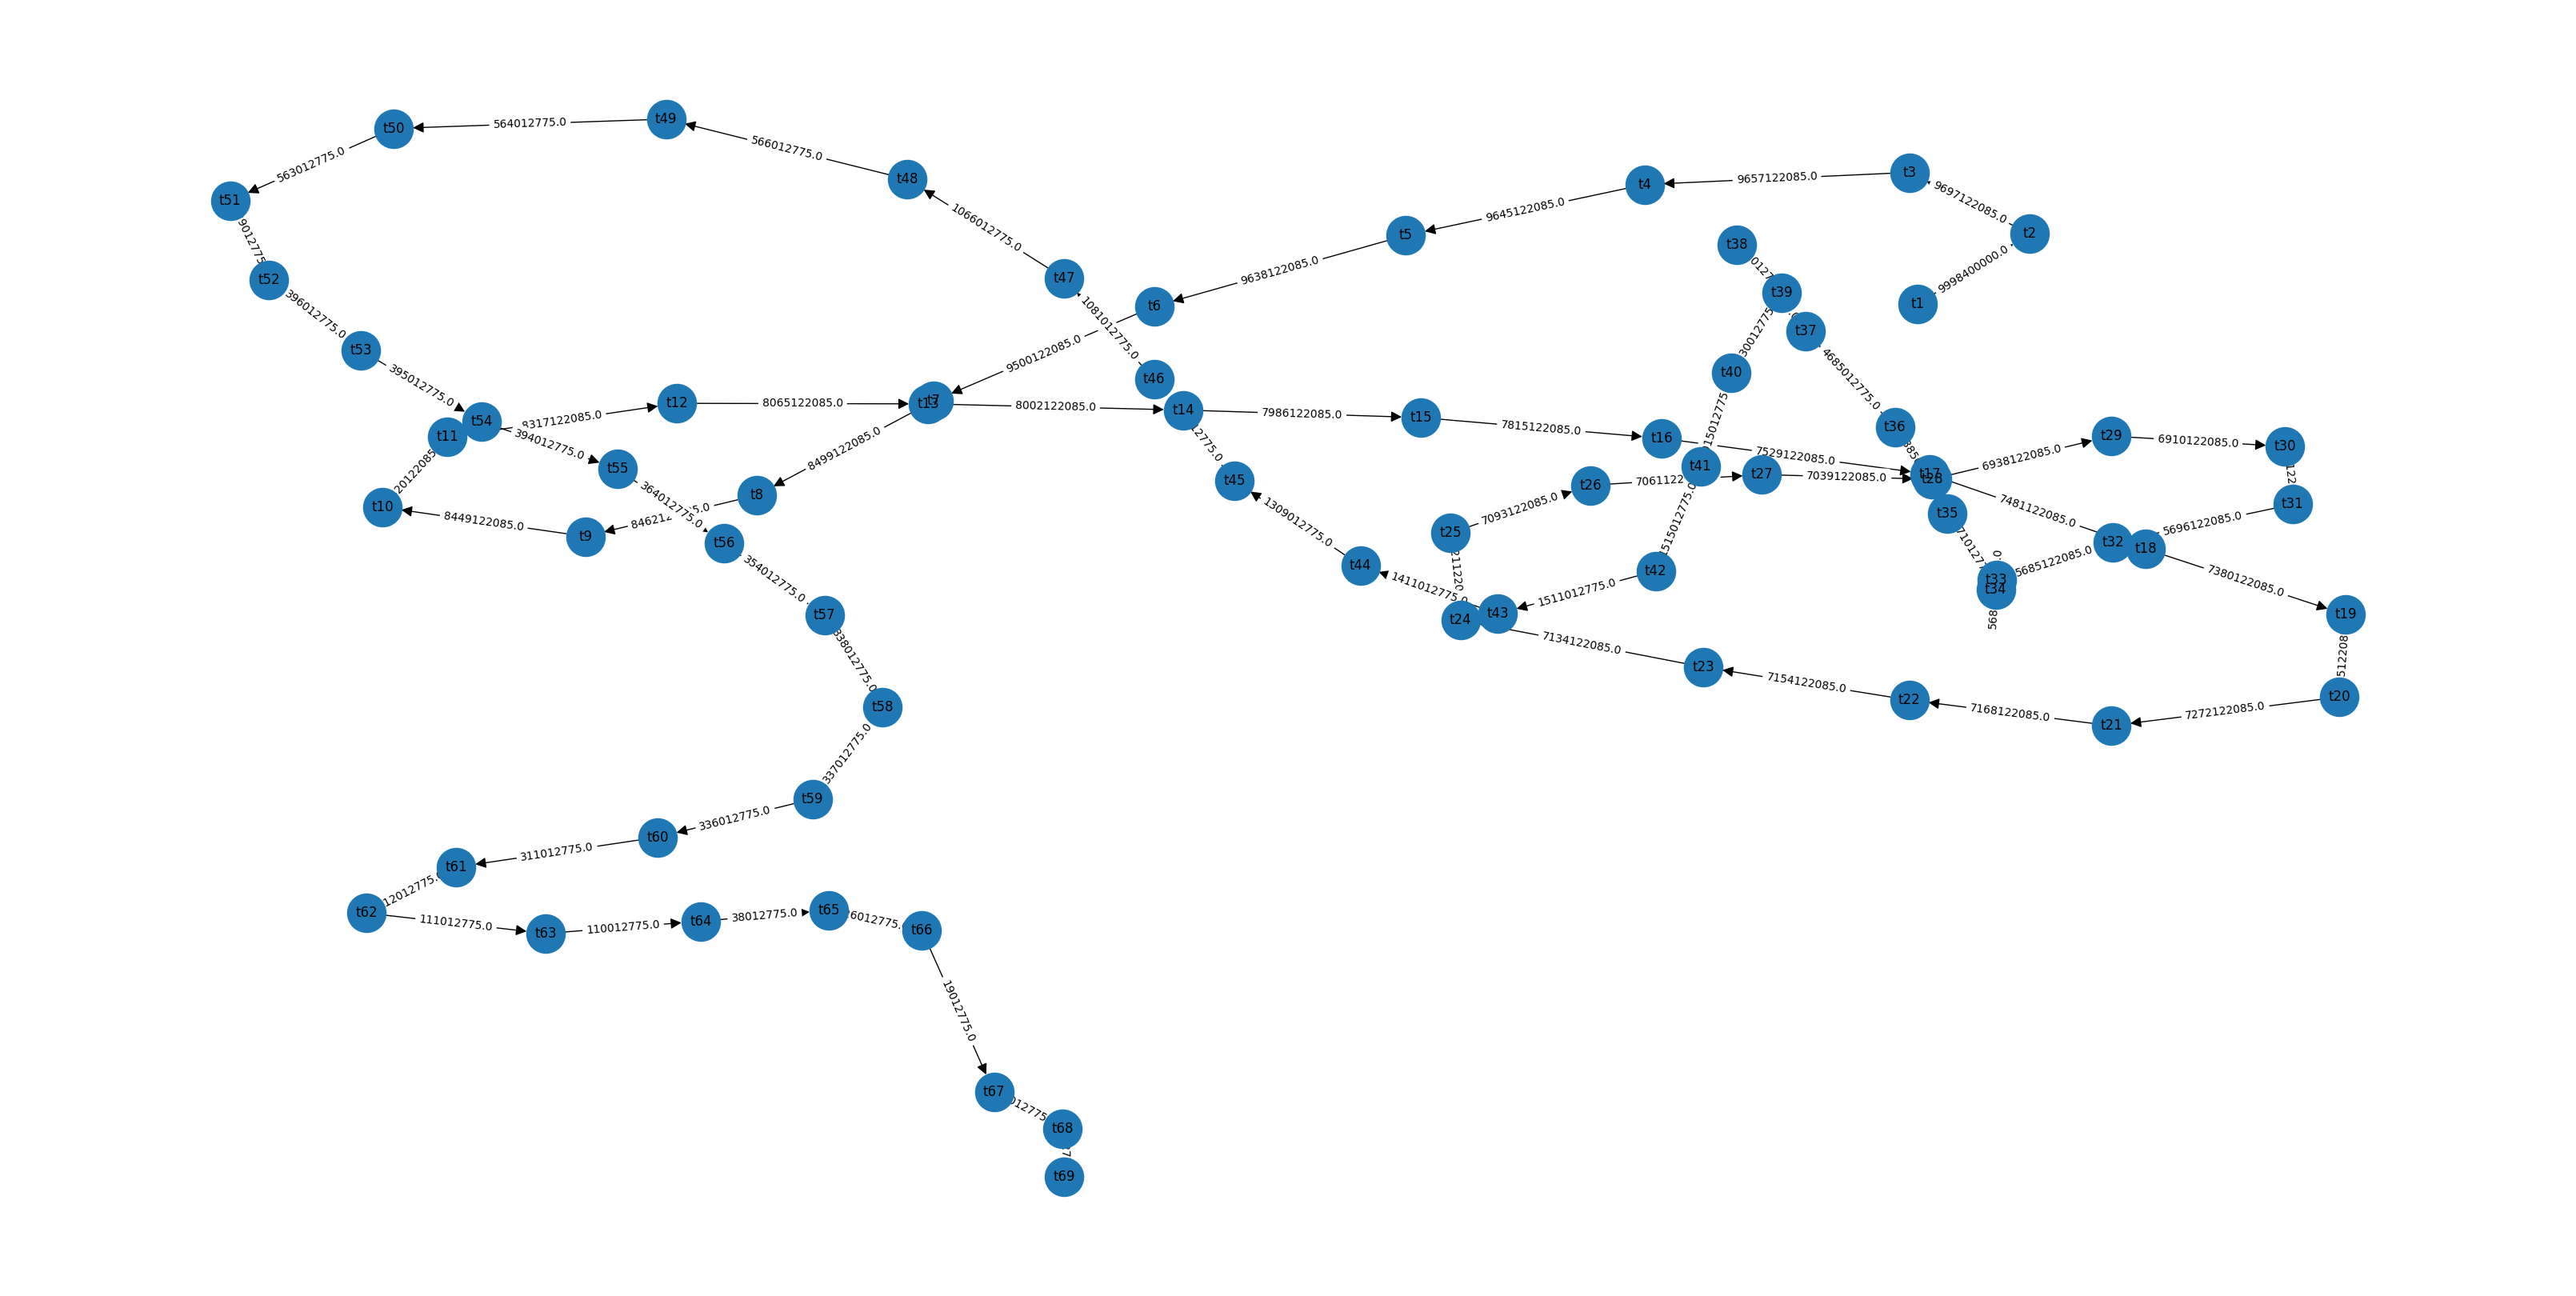

In [25]:

differences,G = create_graph(change_addresses_transactions)

plt.figure(figsize=(32,16))
pos = nx.spring_layout(G) # usa default k
nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u,v): d['label'] for u,v,d in G.edges(data=True)})
plt.show()

<img src="">


<img src="images/catena 3.png">

#### Grafico Descrittivo

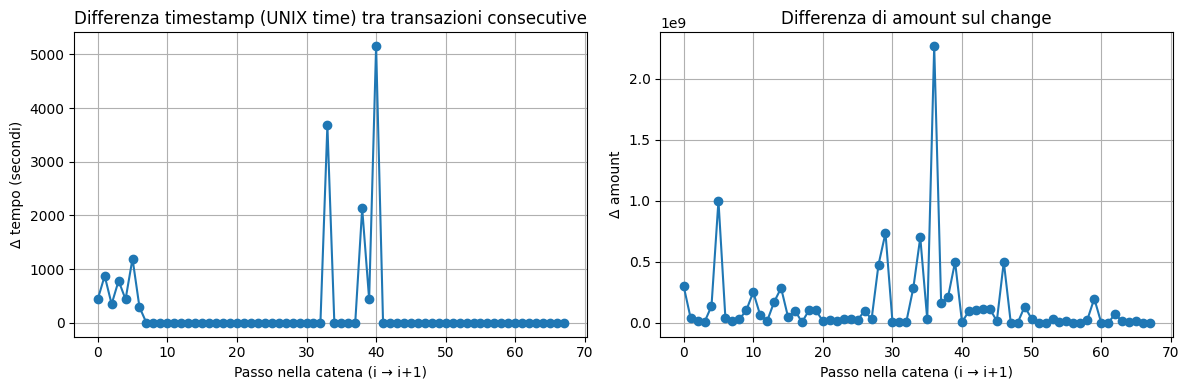

In [26]:
diffs_df = pd.DataFrame(differences)
x = range(len(diffs_df))

plt.figure(figsize=(12,4))

# Δ tempo
plt.subplot(1,2,1)
plt.plot(x, diffs_df["delta_time"], marker="o")
plt.xlabel("Passo nella catena (i → i+1)")
plt.ylabel("Δ tempo (secondi)")
plt.title("Differenza timestamp (UNIX time) tra transazioni consecutive")
plt.grid(True)

# Δ amount
plt.subplot(1,2,2)
plt.plot(x, diffs_df["delta_amount"], marker="o")
plt.xlabel("Passo nella catena (i → i+1)")
plt.ylabel("Δ amount")
plt.title("Differenza di amount sul change")
plt.grid(True)

plt.tight_layout()
plt.show()


### Ipotesi sul Comportamento degli Utenti

L'analisi della catena di transazioni partendo da txId 1883820 rivela un pattern caratteristico del funzionamento delle mining pool nel periodo 2009-2012:

**Pattern Identificato**: La catena mostra transazioni consecutive con intervalli temporali variabili e importi decrescenti, tipici di un sistema di pagamento automatico della mining pool verso i propri miners.

**Spiegazione del Comportamento**:
- Deepbit.net accumulava le ricompense (coinbase + fee) in un indirizzo principale
- Periodicamente, distribuiva i pagamenti ai miners usando sempre lo stesso pattern: inviava l'importo dovuto al miner e restituiva il resto (change) a un nuovo indirizzo Deepbit
- Il change veniva poi riutilizzato per il pagamento successivo, creando così una catena lineare
- Gli indirizzi in `othersDeepbit` rappresentano i miners che ricevevano i pagamenti

**Conferme**: 
- La presenza di un solo output Deepbit per transazione indica l'uso sistematico di change addresses
- La variabilità dei timestamp riflette la frequenza dei pagamenti ai miners
- Gli importi decrescenti mostrano il progressivo svuotamento del wallet principale


### Secondo passo di scraping da WalletExplorer per individuare indirizzi deanonimizzati

Per individuare indirizzi non deanonimizzati predisponiamo 2 funzioni:
**is_deanonimizato**: ritorna un booleano, **True** se il **wallet_name**, passato come formale, è riconducibile ad un servizio reale quindi è stato deanonimizzato, altrimenti **False**
**identify_address**: ritorna un **wallet_name** tramite scraping su walletExplorer, mediante BeautifulSoup aggiungendo all'url di walletExplorer l'**address** passato come formale alla funzione

In [27]:
def is_deanonimizzato(wallet_name):
    w = wallet_name.lower()
    # 1) se contiene un dominio → servizio reale
    if any(ext in w for ext in [".com", ".net", ".org", ".io"]):
        return True
    
    # 2) se è uno dei servizi noti → deanonimizzato
    known = ["deepbit", "diceoncrack", "mtgox", "bitcoinmarket", "slush", "bitminter"]
    if any(k in w for k in known):
        return True
    
    # se non rientra nei casi sopra → NON deanonimizzato
    return False

def identify_address(address):
    res = requests.get(f'{wallet_explorer_url}/address/{address}',headers=headers_address)
    soup = BeautifulSoup(res.text,"html.parser")
    wallet_name = soup.select_one('span.wallet_name').text
    
    match = re.search(r"\[(.*?)\]", wallet_name)
    
    if match:
        wallet_name = match.group(1)

    return wallet_name;

Andiamo quindi a generare, tramite list comprehension una lista di indirizzi, filtrando la colonna di **addressId** di **mapping_df** con ogni indirizzo di **othersDeepBit**, derivato dalla precedente analisi, per ottenere il rispettivo valore della colonna **hash**, successivamente andremo ad invocare la funzione **is_deanonimizzato** su tutti gli indirizzi hashati appena ricavati, creando la lista **others_deanon**.

Infine creaiamo un set **deanonized** tramite comprehension su **others_deanon** cercando solo valori **True**

In [28]:
othersDeepbit = [mapping_df[mapping_df["addressId"] == address].iloc[0]["hash"] for address in othersDeepbit]
others_deanon = [is_deanonimizzato(identify_address(address)) for address in othersDeepbit]
deanonized = set(address for address in others_deanon if address == True)

### Riflessione sui risultati

Effettuando lo scraping degli indirizzi contenuti nell’insieme OthersDeepbit, solo un indirizzo risulta associato a un wallet deanonimizzato su WalletExplorer.

Questo risultato è coerente con il periodo storico del dataset (2009–2012), in cui la maggior parte degli indirizzi apparteneva a utenti privati e WalletExplorer era in grado di identificare solo alcuni grandi servizi pubblici (exchange, mining pool, gambling, merchant).

Gli indirizzi esterni che compaiono nella catena di pagamenti di Deepbit rappresentano prevalentemente utenti individuali della mining pool, che generavano nuovi indirizzi ad ogni transazione e non lasciavano tracce pubbliche della loro identità.

Il fatto che quasi tutti i wallet rimangano anonimi conferma quindi che la catena analizzata non coinvolge servizi pubblici noti e che WalletExplorer non dispone di informazioni sufficienti per collegare questi indirizzi a entità reali.


## 3 Analisi del servizio di gambling DiceOnCrack

#### Definizione Funzioni Per analisi

Per analizzare i dati di DiceOnCrack abbiamo predisposto alcune funzioni, sono state suddivise in più blocchi perchè ricoprono diverse funzionalità, e verranno presentate subito prima del loro uso.

il primo blocco sono funzioni che servono per ricavare tutte le transazioni di input da DiceOnCrack, con le prime due che servono per generare on demand delle maschere da applicare al dataframe **merged_outputs**

In [29]:
def height_mask(height,desired_day_trans): return desired_day_trans["block_height"] == height 

def map_outputs_mask(input): return (merged_outputs["tx_id"] == input["prev_tx_id"]) & (merged_outputs["position"] == input["prev_tx_pos"])

def all_tx_inputs(txs): 
    return [
            merged_outputs[map_outputs_mask(trans)].iloc[0]["hash"] 
                for tx in txs 
                    for _,trans in inputs_df[inputs_df["prev_tx_id"] == tx].iterrows()
            ]


Controllo le transazioni di un determinato intervallo temporale **date_range**, che userò per filtrare il dataframe **doc_trans** e ricavare **desired_day_trans** che mi consentirà di ricavare tutti i **block_heights** di quell'intervallo che salveremo nella variabile **unique_heights** infine andremo a creare il dizionario **same_heights** tramite una dictionary comprehension, con le varie altezze come chiavi ed il valore di ritorno di **all_tx_inputs** come valore.  

In [30]:

# Crea un range di date
date_range = pd.date_range(start="2012-12-26", end="2012-12-31", freq='D').date
# Filtra usando isin
desired_day_trans = doc_trans[doc_trans["timestamp"].dt.date.isin(date_range)]

unique_heights = desired_day_trans["block_height"].unique().tolist()

same_heights = {height:all_tx_inputs(desired_day_trans[height_mask(height,desired_day_trans)]["tx_id"].tolist()) for height in unique_heights}

Nel secondo blocco abbiamo delle funzioni dedicate allo scraping:

**retrieve_address_translation_dict**: restituisce un dizionario, che viene creato in base al set passato come parametro formale. Tale dizionario ha come chiavi le **entry** del set, e come valori gli indirizzi scrapati da walletExplorer mediante la funzione **identify_addresses** precedentemente usata come primo passo per deanonimizzare i **wallet address** 

**translate_addresses**: restituisce una lista contenente il valore contenuto nel dizionario **translation_dict** che ha come chiave i vari indirizzi della **address_list**. Sia **address_list** che **translation_dict** sono i parametri formali della funzione e devono essere ovviamente collegati, altrimenti non avremmo una lista con alcuni valori vuoti

**index_block_addresses**: restituisce un dizionario **translated** che viene creato a partire da **block_dict**,dizionario passato come parametro formale alla funzione.
Questa funzione itera sulle chiavi di **block_dict** per popolare **translated** mediante la funzione **translate_addresses**, dove verrà usato **translation_dict** per "tradurre" gli indirizzi hashati in indirizzi "normali"

In [31]:
#ha lo scopo di ridurre lo scraping fornendo un dizionario per "tradurre" gli indirizzi in maniera più veloce
def retireve_address_translation_dict(set): return { entry:identify_address(entry) for entry in set }

def translate_addresses(translation_dict,address_list): return [translation_dict[address] for address in address_list]

def index_block_addresses(block_dict,translation_dict):
    translated = {}
    for key in block_dict:
        for _ in block_dict[key]:
            translated[key] = translate_addresses(translation_dict,block_dict[key])
    return translated



Successivamente si effettua scraping su walletExplorer per sapere a che wallet corrispondono gli indirizzi contenuti in **same_heigts**, questo avviene nella maniera più light possibile a livello di scraping, in quanto ci aspettiamo di avere molti indirizzi uguali, che quindi farebbero scrapare sempre gli stessi wallet, quindi recuperiamo gli indirizzi nel set **unique_addresses**, il quale verrà passato alla funzione **retrieve_address_translation_dict** per avere un **address_translation_dict** tramite il quale potremmo appunto tradurre tutti gli indirizzi hashati presenti nel dizionario **same_heights** 

In [32]:
#ottengo indirizzi unici per ridurre l'impatto dello scraping
unique_addresses = set(addr for key in same_heights for addr in same_heights[key])
print(len(unique_addresses))

37


In [33]:
print("Retrieving addresses from wallet explorer...")
address_translation_dict = retireve_address_translation_dict(unique_addresses)
print(f"{len(address_translation_dict)} addresses retrieved from wallet explorer...")
wallet_addresses = index_block_addresses(same_heights,address_translation_dict)


Retrieving addresses from wallet explorer...
37 addresses retrieved from wallet explorer...


L'ultimo Blocco di funzioni è relativo alla clusterizzazione degli indirizzi:

**clusterize**: la funzione ritorna un dizionario **cluster** che ha come chiavi gli indirizzi di **data**, unico parametro formale della funzione, e come valori la frequenza con cui quell'indirizzo compare in data

**create_clusters**: la funzione ritorna un dizionario di dizionari **cluster** che ha come chiavi del primo dizionario, **block_heigth** e come valore il dizionario creato da **clusterize** con **data[block_height]** come parametro

**cluster_mean**: la funzione ritorna un dizionario **result** con **block** come chiavi e delle stringhe come valori, le stringhe contengono il numero di cluster del blocco e la media di cluster per quel blocco, la media viene calcolata escludendo i cluster con dimensione insferiore a 2


In [34]:
def clusterize(data):
    cluster = {}
    for wallet in data:
        if wallet not in cluster:
            cluster[wallet] = 1
        else:
            cluster[wallet] +=1
    return cluster

def create_clusters(data):
    cluster = {}
    for block_height in data:
        cluster[block_height] = clusterize(data[block_height])
    return cluster

def cluster_mean(clusters):
    result = {}
    for block in clusters:
        i = 0
        mean = 0 
        for cluster in clusters[block]:
            dim = clusters[block][cluster]
            if cluster == "DiceOnCrack.com": continue
            if dim<2:continue
            i+=1
            mean+=dim
        if i<= 0: continue 
        mean = mean/i
        result[block] = f'num cluster: {i}, mean:{mean}'
        mean = 0
        i = 0
    return result

Infine andiamo ad analizzare i cluster di indirizzi.

Per Cluster intendiamo un `insieme di input derivati da tx_ids nello stesso block_height e che hanno stesso wallet di provenienza`, avendo già un dizionario con **block_height** come chiave, andiamo a creare i cluster mediante la funzione **create_clusters** ed infine andiamo a calcolare la dimensiona media di ogni cluster per blocco, escludendo cluster di dimensione < 2 tramite la funzione **cluster_mean**

In [35]:

clusterized_wallets = create_clusters(wallet_addresses)

cluster_dict = cluster_mean(clusterized_wallets)

In [43]:
display(cluster_dict)

{213645: 'num cluster: 1, mean:2.0',
 213651: 'num cluster: 1, mean:3.0',
 213653: 'num cluster: 1, mean:2.0',
 213654: 'num cluster: 2, mean:2.5',
 213659: 'num cluster: 1, mean:3.0',
 213739: 'num cluster: 1, mean:2.0',
 213780: 'num cluster: 1, mean:3.0',
 213789: 'num cluster: 1, mean:18.0',
 213790: 'num cluster: 1, mean:18.0',
 213792: 'num cluster: 1, mean:7.0',
 213800: 'num cluster: 1, mean:3.0',
 213805: 'num cluster: 1, mean:8.0',
 213812: 'num cluster: 1, mean:2.0',
 213841: 'num cluster: 1, mean:6.0',
 213842: 'num cluster: 1, mean:6.0',
 213843: 'num cluster: 1, mean:6.0',
 213844: 'num cluster: 1, mean:2.0',
 213865: 'num cluster: 1, mean:2.0',
 213897: 'num cluster: 2, mean:3.0',
 213898: 'num cluster: 1, mean:2.0',
 213899: 'num cluster: 1, mean:2.0',
 213901: 'num cluster: 1, mean:4.0',
 213903: 'num cluster: 1, mean:4.0',
 213904: 'num cluster: 1, mean:7.0',
 213905: 'num cluster: 1, mean:3.0',
 213907: 'num cluster: 1, mean:2.0',
 213909: 'num cluster: 1, mean:6.0',

Di seguito andiamo a rappresentare su un grafico i dati appena ottenuti per visualizzare meglio i risultati

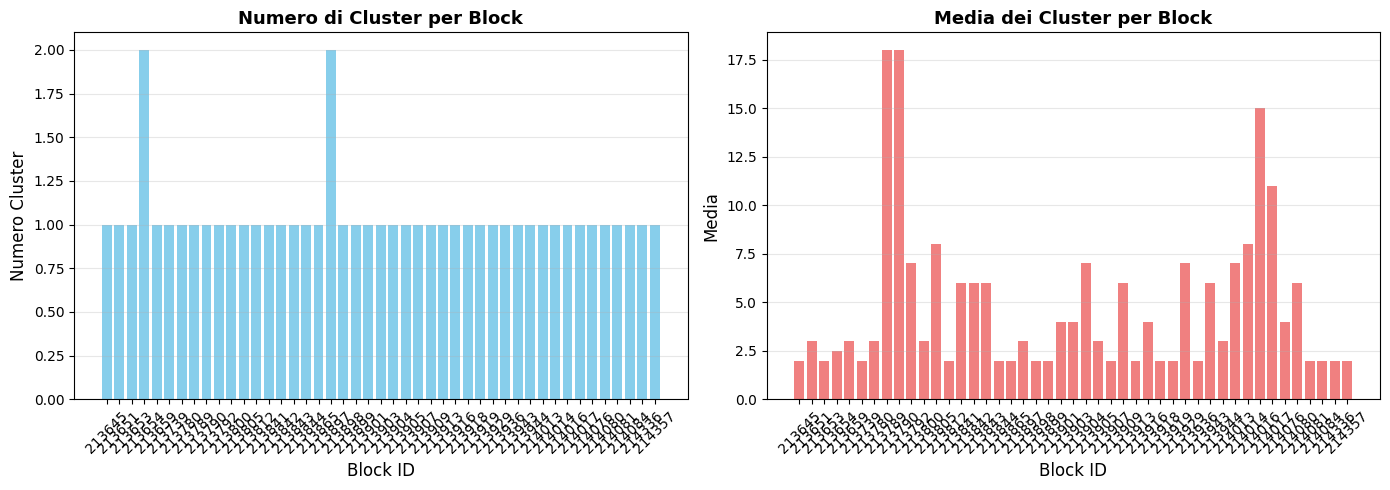

In [36]:
# Estrazione dei dati (stesso di prima)
block_ids = [k for k in cluster_dict.keys()]
num_clusters = []
means = []

for value in cluster_dict.values():
    parts = value.split(', ')
    num_cluster = int(parts[0].split(':')[1].strip())
    mean = float(parts[1].split(':')[1].strip())
    num_clusters.append(num_cluster)
    means.append(mean)

# Creazione di due subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Primo grafico: Numero di cluster
ax1.bar(range(len(block_ids)), num_clusters, color='skyblue')
ax1.set_xlabel('Block ID', fontsize=12)
ax1.set_ylabel('Numero Cluster', fontsize=12)
ax1.set_title('Numero di Cluster per Block', fontsize=13, fontweight='bold')
ax1.set_xticks(range(len(block_ids)))
ax1.set_xticklabels(block_ids, rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Secondo grafico: Media
ax2.bar(range(len(block_ids)), means, color='lightcoral')
ax2.set_xlabel('Block ID', fontsize=12)
ax2.set_ylabel('Media', fontsize=12)
ax2.set_title('Media dei Cluster per Block', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(block_ids)))
ax2.set_xticklabels(block_ids, rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


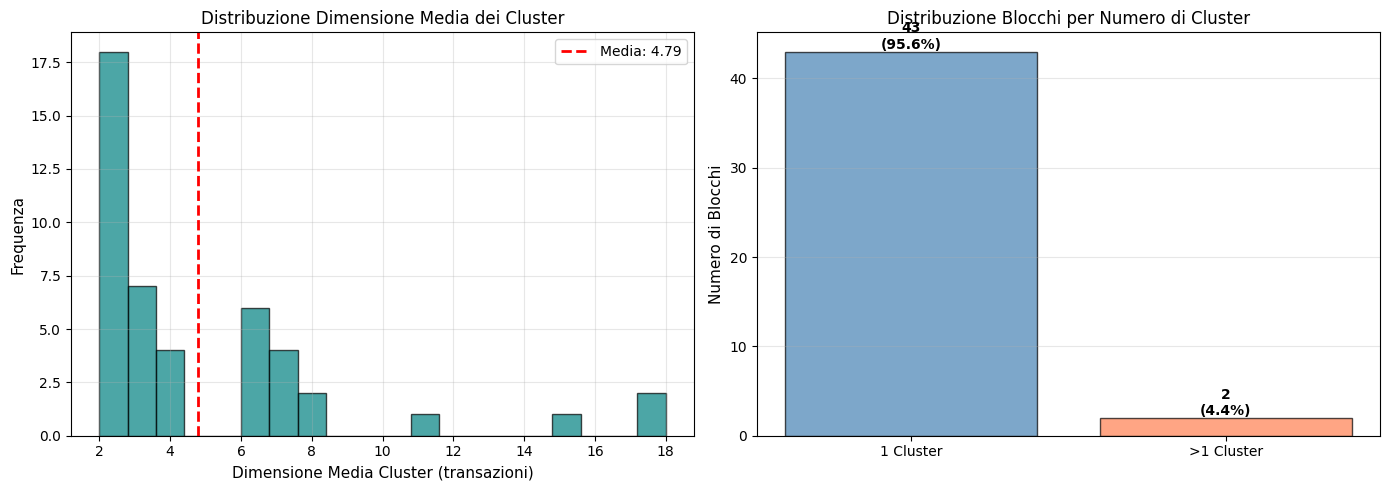

Blocchi totali: 45
Dimensione media: 4.79 transazioni
Dimensione massima: 18.0 transazioni
Blocchi con cluster multipli: 2


In [45]:
# Grafici usando direttamente clusters_per_block
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Distribuzione dimensione media dei cluster
mean_sizes = [float(info.split('mean:')[1]) for info in cluster_dict.values()]

axes[0].hist(mean_sizes, bins=20, color='teal', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Dimensione Media Cluster (transazioni)', fontsize=11)
axes[0].set_ylabel('Frequenza', fontsize=11)
axes[0].set_title('Distribuzione Dimensione Media dei Cluster', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axvline(np.mean(mean_sizes), color='red', linestyle='--', 
                linewidth=2, label=f'Media: {np.mean(mean_sizes):.2f}')
axes[0].legend()

# Grafico 2: Numero di cluster per block
num_clusters = [int(info.split('num cluster: ')[1].split(',')[0]) 
                for info in cluster_dict.values()]

single = num_clusters.count(1)
multi = len(num_clusters) - single

axes[1].bar(['1 Cluster', '>1 Cluster'], [single, multi],
            color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Numero di Blocchi', fontsize=11)
axes[1].set_title('Distribuzione Blocchi per Numero di Cluster', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Percentuali
total = len(cluster_dict)
axes[1].text(0, single, f'{single}\n({single/total*100:.1f}%)', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[1].text(1, multi, f'{multi}\n({multi/total*100:.1f}%)', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistiche
print(f"Blocchi totali: {len(cluster_dict)}")
print(f"Dimensione media: {np.mean(mean_sizes):.2f} transazioni")
print(f"Dimensione massima: {max(mean_sizes):.1f} transazioni")
print(f"Blocchi con cluster multipli: {multi}")


### Discussione sul Comportamento dei Gambler

**Pattern Osservato nei Dati**: L'analisi rivela che la maggior parte dei cluster contiene 
2-3 transazioni consecutive (picco della distribuzione), con una media di 4.79 alzata da 
outliers che arrivano fino a 18 transazioni. Il 95.6% dei blocchi contiene un solo cluster, 
indicando bassa concorrenza tra gambler.

**Interpretazione del Comportamento**:

1. **Gambler Tipico (2-3 transazioni)**: La concentrazione su poche scommesse consecutive 
suggerisce sessioni brevi in cui l'utente effettuava puntate multiple in rapida successione 
(~10 minuti) senza attendere conferme. Questo è coerente con strategie "raddoppia dopo perdita" 
limitate o test del servizio.

2. **Gambler Compulsivo/Automatizzato (12-18 transazioni)**: Gli outliers indicano uso di 
bot per scommesse automatiche o strategie Martingala prolungate, dove il giocatore raddoppia 
sistematicamente la puntata dopo ogni perdita generando burst di transazioni consecutive.

3. **Volume di Utenti Limitato**: Solo il 4.4% dei blocchi mostra attività simultanea di 
più wallet, confermando che DiceOnCrack aveva un traffico ridotto nel periodo 2009-2012, 
coerente con l'adozione limitata di Bitcoin all'epoca.

**Conferme Statistiche**:
- La distribuzione asimmetrica (media 4.79 >> mediana ~2.5) evidenzia comportamenti eterogenei
- La varietà 2-18 transazioni mostra lo spettro dal giocatore occasionale al compulsivo
- La concentrazione temporale (stesso block) conferma intenzionalità delle sequenze
